In [2]:
import numpy as np 
import matplotlib.pyplot as plt

In [4]:
import probfit

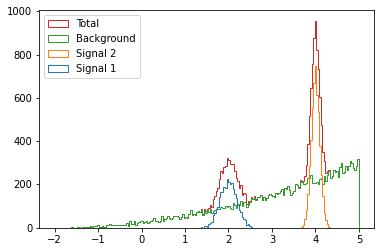

In [5]:

# Generate some example data
np.random.seed(0)
data_peak1 = np.random.randn(3000) * 0.2 + 2
data_peak2 = np.random.randn(5000) * 0.1 + 4
data_range = (-2, 5)
data_bg = probfit.gen_toy(lambda x : 4 + 4 * x + x ** 2, 20000, data_range)
data_all = np.concatenate([data_peak1, data_peak2, data_bg])
plt.hist((data_peak1, data_peak2, data_bg, data_all),
         label=['Signal 1', 'Signal 2', 'Background', 'Total'],
         bins=200, histtype='step', range=data_range)
plt.legend(loc='upper left');

In [19]:

# Using a polynomial to fit a distribution is problematic, because the
# polynomial can assume negative values, which results in NaN (not a number)
# values in the likelihood function.
# To avoid this problem we restrict the fit to the range (0, 5) where
# the polynomial is clearly positive.
fit_range = (0, 5)
normalized_poly = probfit.Normalized(probfit.Polynomial(2), fit_range)
normalized_poly = probfit.Extended(normalized_poly, extname='NBkg')

def mygauss(x,mu1,sigma1):
    return probfit.gaussian(x,mu1,sigma1)

gauss1 = probfit.Extended(mygauss, extname='N1')
gauss2 = probfit.Extended(probfit.gaussian, extname='N2')

# Define an extended PDF consisting of three components
pdf = probfit.AddPdf(normalized_poly, gauss1, gauss2)

print('normalized_poly: {}'.format(probfit.describe(normalized_poly)))
print('gauss1:          {}'.format(probfit.describe(gauss1)))
print('gauss2:          {}'.format(probfit.describe(gauss2)))
print('pdf:             {}'.format(probfit.describe(pdf)))

normalized_poly: ('x', 'c_0', 'c_1', 'c_2', 'NBkg')
gauss1:          ('x', 'mu1', 'sigma1', 'N1')
gauss2:          ('x', 'mean', 'sigma', 'N2')
pdf:             ('x', 'c_0', 'c_1', 'c_2', 'NBkg', 'mu1', 'sigma1', 'N1', 'mean', 'sigma', 'N2')


In [20]:
import iminuit

AttributeError: 'Minuit' object has no attribute 'args'

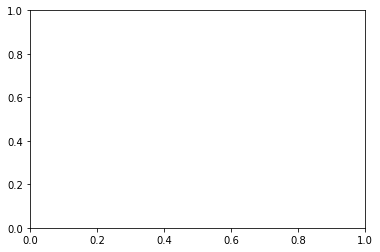

In [26]:
# Define the cost function in the usual way ...
binned_likelihood = probfit.BinnedLH(pdf, data_all, bins=200, extended=True, bound=fit_range)

# This is a quite complex fit (11 free parameters!), so we need good starting values.
# Actually we even need to set an initial parameter error
# for 'mu1' and 'mu2' to make MIGRAD converge.
# The initial parameter error is used as the initial step size in the minimization.
pars = dict(mu1=1.9, sigma1=0.2, N1=3000,
            mean=4.1,  sigma=0.1, N2=5000,
            c_0=4, c_1=4, c_2=1, NBkg=20000)
minuit = iminuit.Minuit(binned_likelihood,  **pars)
# You can see that the model already roughly matches the data
binned_likelihood.draw(minuit, parts=True);